# PVRNN.ipynb

A PyTorch implementation of the [PVRNN](https://direct.mit.edu/neco/article/31/11/2025/95667/A-Novel-Predictive-Coding-Inspired-Variational-RNN)

The architecture is restricted to two layers, with the top (context) layer containing LSTM units (not MTRNN).  
This implementation contains modifications from papers that followed the original 2019 PVRNN, a bit like [this](https://www.frontiersin.org/articles/10.3389/fnbot.2020.00061/full)


In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import lovely_tensors as lt
lt.monkey_patch()
%cd ./data/

/home/z/Dropbox (OIST)/code/python/pytorch/deep_explorations/rnn/data


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cuda:0


In [3]:
# Load training trajectories
coordinates = []
#fnames = ['cte' + str(i) + '.pkl' for i in range(1,9)]
# fnames = ['circle2_triangle2_eight2_random.pkl']
fnames = ['circle10_1.pkl']
for fname in fnames:
    with open(fname, 'rb') as f:
        coordinates.append(pickle.load(f))

Coordinates[0] shape: torch.Size([882, 2])


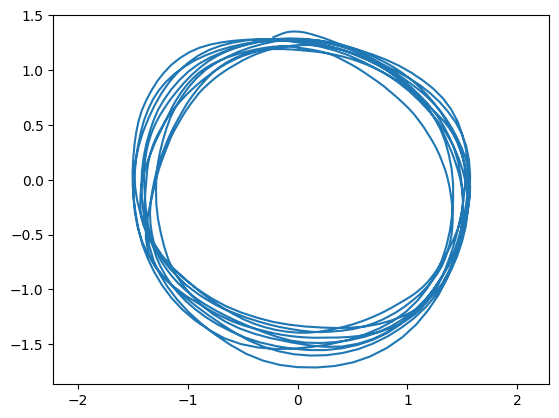

In [4]:
# plot the loaded array
fig = plt.figure()
plt.axis('equal')
if type(coordinates) == list:
    coords = coordinates[0]
    plt.plot(coords[:,0], coords[:,1])
    for i in range(len(coordinates)):
        coordinates[i] = torch.tensor(coordinates[i], dtype=torch.float32)
        print(f"Coordinates[{i}] shape: {coordinates[i].shape}")
else:
    plt.plot(coordinates[:,0], coordinates[:,1])
    coordinates = torch.tensor(coordinates, dtype=torch.float32)
    print(f"Coordinates shape: {coordinates.shape}")

In [5]:
# Utility function

class FFP(nn.Module):
    """ A feedforward perceptron. """
    def __init__(self, sizes, nltypes, bias=True):
        """
            sizes: list with size of each layer.
            nltypes: list with nonlinearity type for each inner or
                output layer. Entries are 'relu', 'sig', 'tanh', 'soft',
                or 'linear'.
            bias: whether the layers have a bias unit
        """
        assert len(sizes)-1 == len(nltypes), "length mismatch in nltypes, sizes"
        super(FFP, self).__init__()
        # Add activation functions
        self.nlfs = []
        for nltype in nltypes:
            if nltype == "relu":
                self.nlfs.append(nn.ReLU())
            elif nltype == "sig":
                self.nlfs.append(nn.Sigmoid())
            elif nltype == "tanh":
                self.nlfs.append(nn.Tanh())
            elif nltype == "soft":
                self.nlfs.append(nn.Softplus())
            elif nltype == "linear":
                self.nlfs.append("linear")
            else:
                raise ValueError(f"unknown nonlinearity {nltype}")
        # create layers
        self.bias = bias
        self.sizes = sizes
        layers = []
        for lidx in range(1,len(sizes)):
            layers.append(nn.Linear(sizes[lidx-1], sizes[lidx], bias=bias))
        self.layers = nn.ModuleList(layers)
                
    def forward(self, x):
        for lidx, layer in enumerate(self.layers):
            if self.nlfs[lidx] == "linear":
                x = layer(x)
            else:
                x = self.nlfs[lidx](layer(x))
        return x

In [6]:
class PVRNN(nn.Module):
    """ Implementation of a basic PV-RNN network with two layers. 
    
        All networks in the fast context layer (layer 1) are feedforward
        perceptrons implemented with the FFP class. The slow context layer
        (layer 2) consists of FFP objects and an LSTM cell.

        Bottom-up connections have been removed, and top-down propagation
        occurs in the same time step.
    """
    def __init__(self,
                 prior_conf1, 
                 hid_conf,
                 dec_conf,
                 prior_conf2,
                 lstm_conf,
                 gen_conf):
        """ Class constructor.

            The constructor receives the configuration dictionaries
            that the FFP class uses to build the networks, plus an
            extra configuration dictionary for general parameters.

            Args:
                prior_conf1: Config. for the layer 1 prior encoder.
                dec_conf: Config. Dict. for the decoder.
                hid_conf: Config. Dict. for the hidden state function.
                prior_conf2: Config. for the layer 2 prior encoder.
                lstm_conf: Config. for the layer 2 LSTM cell. Entries are
                          'input_size', 'hidden_size', 'bias'
                gen_conf: Config. Dict. with the following entries...
                          m: number of steps for error regression.
                          min_loss: stop updating A if loss reaches this.
                          max_iter: stop updating A if iterations reach this.
                          A_lr: learning rate for updating of A vectors.
        """
        super(PVRNN, self).__init__()

        self.test_configs(prior_conf1, hid_conf, dec_conf,
                          prior_conf2, lstm_conf, gen_conf)
                     
        self.f_p1 = FFP(prior_conf1['sizes'],
                            prior_conf1['nltypes'],
                            prior_conf1['bias']).to(device)
        self.f_hid = FFP(hid_conf['sizes'],
                         hid_conf['nltypes'],
                         hid_conf['bias']).to(device)
        self.f_dec = FFP(dec_conf['sizes'],
                         dec_conf['nltypes'],
                         dec_conf['bias']).to(device)
        self.f_p2 = FFP(prior_conf2['sizes'],
                            prior_conf2['nltypes'],
                            prior_conf2['bias']).to(device)
        self.lstm = nn.LSTMCell(lstm_conf['input_size'],
                                lstm_conf['hidden_size'],
                                bias=lstm_conf['bias'],
                                device=device)
        self.mse_loss = nn.MSELoss(reduction='mean')
                     
        self.d1_n = hid_conf['sizes'][-1]
        self.d2_n = lstm_conf['hidden_size']
        self.x_n = dec_conf['sizes'][-1]
        self.z1_n = int(prior_conf1['sizes'][-1] / 2)
        self.z2_n = int(prior_conf2['sizes'][-1] / 2)
        self.m = gen_conf['m']
        self.min_loss = gen_conf['min_loss']
        self.max_iter = gen_conf['max_iter']
        self.A_lr = gen_conf['A_lr']
        self.all_mu_pz1 = None
        self.all_sigma_pz1 = None
        self.all_mu_qz1 = None
        self.all_sigma_qz1 = None
        self.all_mu_pz2 = None
        self.all_sigma_pz2 = None
        self.all_mu_qz2 = None
        self.all_sigma_qz2 = None
                 
    def generate(self, T):
        """ Generate T values of x using the z prior distribution. 
        
            Returns a tensor with shape (T, self.x_n)
        """
        d1 = torch.zeros(self.d1_n, device=device)
        d2 = torch.zeros(self.d2_n, device=device)  # hidden state for layer 2 LSTM
        c = torch.zeros(self.d2_n, device=device)  # cell state for layer 2 LSTM
        all_x = torch.empty((T, self.x_n), device=device)
        for t in range(T):
            # sample z1, z2 from prior
            z1, z2 = self.sample_prior(d1, d2)
            # layer 2 lstm state
            d2, c = self.lstm(z2, (d2, c))
            # layer 1 hidden activity
            d1 = self.f_hid(torch.cat((d1, d2, z1)))
            # output
            x = self.f_dec(d1)
            # store x value
            all_x[t, :] = x
        return all_x

    def sample_prior(self, d1, d2, store=False, t=None):
        """ Sample z1, z2 from the prior distribution.

            Gaussian distribution parameters are obtaind from f_p1(d1),
            f_p2(d2), and sampling is done with reparameterization.

            Optionally, the parameters of the distribution can be
            stored at in the object's buffers at position t.
        """
        # prior for z2
        prior2 = self.f_p2(d2)
        mu_pz2 = prior2[:self.z2_n]
        sigma_pz2 = prior2[self.z2_n:].exp()
        # sample z2 with reparameterization
        eps2 = torch.randn_like(mu_pz2)
        z2 = eps2.mul(sigma_pz2).add_(mu_pz2)
        # prior for z1
        prior1 = self.f_p1(d1)
        mu_pz1 = prior1[:self.z1_n]
        sigma_pz1 = prior1[self.z1_n:].exp()
        # sample z1 with reparameterization
        eps1 = torch.randn_like(mu_pz1)
        z1 = eps1.mul(sigma_pz1).add_(mu_pz1)
        if store:
            self.all_mu_pz1[t, :] = mu_pz1
            self.all_mu_pz2[t, :] = mu_pz2
            self.all_sigma_pz1[t, :] = sigma_pz1
            self.all_sigma_pz2[t, :] = sigma_pz2
        return z1, z2

    def forward(self, x):
        """ Perform inference for a sequence of inputs.

            Args:
                x: tensor with shape (T, x_n)
            Returns the inferred x values (tensor with shape (T, x_n))

            In addition, the object's buffers will be updated to contain:
            prior mu_z1 values, shape (T, n_z)
            prior sigma_z1 values, shape (T, n_z)
            posterior mu_z1 values, shape (T, n_z)
            posterior sigma_z1 values, shape (T, n_z)
            prior mu_z2 values, shape (T, n_z)
            prior sigma_z2 values, shape (T, n_z)
            posterior mu_z2 values, shape (T, n_z)
            posterior sigma_z2 values, shape (T, n_z)
        """
        T = x.shape[0]
        self.init_buffers(T)
        A1 = torch.zeros((T, 2 * self.z1_n), requires_grad=True, device=device)
        A2 = torch.zeros((T, 2 * self.z2_n), requires_grad=True, device=device)
        A_optim = torch.optim.Adam([A1, A2], lr=self.A_lr)
        # Obtaining A1, A2 with BPTT
        loss = self.min_loss + 1.
        iter = 0
        while loss > self.min_loss and iter < self.max_iter:
            A_optim.zero_grad()
            self.zero_grad()
            iter += 1
            # predict the x sequence
            x_hat = self.generate_from_posterior(T, A1, A2, store=False)
            # loss
            A_loss = self.mse_loss(x, x_hat)
            if iter == 1:
                print(f"Initial A loss: {A_loss}")
            # backpropagation
            A_loss.backward()
            # update A1, A2
            A_optim.step()
        print(f"Final A loss: {A_loss}")
            
        # Obtaining predictions and posterior parameters with A1, A2
        x_hat = self.generate_from_posterior(T, A1, A2, store=True)
        return x_hat

    def generate_from_posterior(self, T, A1, A2, store=False):
        """ Generate T outputs given the A1, A2 tensors.

            A1 and A2 must be tensors with shape (K, 2*self.z1_n) and
            (K, 2*self.z2_n) respectively, where K >= T.
        
            This method returns a tensor of shape (T, self.x_n).
            
            Optionally, the network's RNN states and the parameters for the
            posterior and prior distributions at each time step can be stored
            in the object's buffer when store==True.
        """
        d1 = torch.zeros(self.d1_n, device=device)
        d2 = torch.zeros(self.d2_n, device=device)  # hidden state for layer 2 LSTM
        c = torch.zeros(self.d2_n, device=device)  # cell state for layer 2 LSTM
        all_x = torch.empty((T, self.x_n), device=device)
        for t in range(T):
            if store:
                self.sample_prior(d1, d2, store=True, t=t)
                
            x, d1, d2, c  = self.prediction_step(A1, A2, d1, d2, c, t,
                                                 store=store)
            all_x[t, :] = x
        return all_x
    
    def prediction_step(self, A1, A2, d1, d2, c, t, store=False):
        """ Update internal states and predict x(t). 
        
            Returns a tuple with (x, d1, d2, c).

            If store==True the internal states and the parameters
            for the posterior distribution will be appended to the 
            network's buffers at position t.
        """
        # posterior for z1, z2
        z1, z2 = self.sample_posterior(A1, A2, t, store=store)
        # layer 2 lstm state
        d2, c = self.lstm(z2, (d2, c))
        # layer 1 RNN
        d1 = self.f_hid(torch.cat((d1, d2, z1)))
        # predict x
        x = self.f_dec(d1)
        return x, d1, d2, c

    def sample_posterior(self, A1, A2, t, store=False):
        mu_qz1 = nn.Tanh()(A1[t, :self.z1_n])
        sigma_qz1 = A1[t, self.z1_n:].exp()
        mu_qz2 = nn.Tanh()(A2[t, :self.z2_n])
        sigma_qz2 = A2[t, self.z2_n:].exp()
        # sample z1, z2 with reparameterization
        eps1 = torch.randn_like(mu_qz1)
        z1 = eps1.mul(sigma_qz1).add_(mu_qz1)
        eps2 = torch.randn_like(mu_qz2)
        z2 = eps2.mul(sigma_qz2).add_(mu_qz2)
        if store:
            self.all_mu_qz1[t, :] = mu_qz1
            self.all_sigma_qz1[t, :] = sigma_qz1
            self.all_mu_qz2[t, :] = mu_qz2
            self.all_sigma_qz2[t, :] = sigma_qz2
        return z1, z2
            
    def init_buffers(self, T):
        """ Initialize tensors to store previous distribution parameters."""
        self.all_mu_pz1 = torch.empty((T, self.z1_n), device=device)
        self.all_sigma_pz1 = torch.empty((T, self.z1_n), device=device)
        self.all_mu_qz1 = torch.empty((T, self.z1_n), device=device)
        self.all_sigma_qz1 = torch.empty((T, self.z1_n), device=device)
        self.all_mu_pz2 = torch.empty((T, self.z2_n), device=device)
        self.all_sigma_pz2 = torch.empty((T, self.z2_n), device=device)
        self.all_mu_qz2 = torch.empty((T, self.z2_n), device=device)
        self.all_sigma_qz2 = torch.empty((T, self.z2_n), device=device)
        
    def test_configs(self, prior_conf1, hid_conf, dec_conf,
                           prior_conf2, lstm_conf, gen_conf):
        """ Test for consistency in some of the layer shapes. """
        d1_n = prior_conf1['sizes'][0]
        d2_n = lstm_conf['hidden_size']
        x_n = dec_conf['sizes'][-1]
        z1_n = int(prior_conf1['sizes'][-1] / 2)
        z2_n = int(prior_conf2['sizes'][-1] / 2)
        assert prior_conf1['sizes'][-1] % 2 == 0, \
            "Output of the layer 1 prior encoder should be an even number"
        assert prior_conf2['sizes'][-1] % 2 == 0, \
            "Output of the layer 2 prior encoder should be an even number"
        assert prior_conf1['sizes'][0] == hid_conf['sizes'][-1], \
            "Inconsistent size for layer 1 RNN output"
        assert hid_conf['sizes'][-1] == d1_n, \
            "Inconsistent size for layer 1 RNN output"
        assert hid_conf['sizes'][0] == d1_n + d2_n + z1_n, \
            f"Layer 1 RNN input size {hid_conf['sizes'][0]} does not match input size {d1_n + d2_n + z1_n}"
        assert lstm_conf['input_size'] == z2_n, \
            f"LSTM input of size {lstm_conf['input_size']} does not match z2_n = {z2_n}"

    def divergences(self):
        """ Kullback-Leibler divergences for prior and posterior distributions.

            The KL divergences are calculated at each time step for both 
            layers, and all terms are summed.

            The constant term in the KL divergence is omitted, because it plays
            no role in backpropagation.
            
            The parameters of the prior and posterior distributions should
            already be stored in the object's buffers, as is the case after
            the `forward(x)` method is called.
        """
        tiny = 1e-16
        log_sig_p1_sum = (self.all_sigma_pz1 + tiny).log().sum()
        log_sig_p2_sum = (self.all_sigma_pz2 + tiny).log().sum()
        log_sig_q1_sum = (self.all_sigma_qz1 + tiny).log().sum()
        log_sig_q2_sum = (self.all_sigma_qz2 + tiny).log().sum()
        mu_diff1 = (self.all_mu_pz1 - self.all_mu_qz1).pow(2)
        mu_diff2 = (self.all_mu_pz2 - self.all_mu_qz2).pow(2)
        KL1 = ((self.all_sigma_qz1.pow(2) + 
                mu_diff1).div(2 * self.all_sigma_pz1.pow(2) + tiny).sum() +
                log_sig_p1_sum - log_sig_q1_sum)
        KL2 = ((self.all_sigma_qz2.pow(2) + 
                mu_diff2).div(2 * self.all_sigma_pz2.pow(2) + tiny).sum() +
                log_sig_p2_sum - log_sig_q2_sum)
        return KL1 + KL2


In [8]:
# Create the network, the optimizer, and the loss function
# NOTICE there are no batches. Learning a single pattern.

lr = 9e-4  # learning rate
x_n = 2  # Input dimension. This shouldn't change
d1_n = 20 # layer 1 hidden state dimension
d2_n = 8 # layer 2 hidden state dimension
z1_n = 4  # layer 1 latent space dimension
z2_n = 2  # layer 2 latent space dimension

prior_conf1 = {'sizes': [d1_n, 2 * z1_n],
               'nltypes': ['tanh'],
               'bias': True }
prior_conf2 = {'sizes': [d2_n, 10, 2 * z2_n],
               'nltypes': ['relu', 'tanh'],
               'bias': True }
hid_conf = {'sizes': [d1_n + d2_n + z1_n, 30, d1_n],
            'nltypes': ['relu', 'tanh'],
            'bias': True }
lstm_conf = {'input_size': z2_n,
             'hidden_size': d2_n,
             'bias': True }
dec_conf = {'sizes': [d1_n, 40, x_n],
            'nltypes': ['relu', 'linear'],
            'bias': True }
gen_conf = {'m': 10,
            'min_loss': 0.1,
            'max_iter': 100,
            'A_lr': 0.01 }

all_generated = []
torch.manual_seed(345)

pvrnn = PVRNN(prior_conf1, 
              hid_conf,
              dec_conf,
              prior_conf2, 
              lstm_conf,
              gen_conf)

optim = torch.optim.Adam(pvrnn.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction='mean')

In [11]:
# training loop
n_epochs = 6  # number of epochs
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)
    
if not 'w' in locals():
    w = 0.
alpha = 5e-7
loss_ratio = 10.  # KL_loss / rec_loss at equilibrium

for epoch in range(n_epochs):
    mean_rec_loss = 0
    mean_KL_loss = 0
    for x in coordinates:
        optim.zero_grad()
        x_hat = pvrnn(x)
        KL_loss = pvrnn.divergences()
        rec_loss = mse_loss(x, x_hat)
        loss = rec_loss + w * KL_loss
        loss.backward()
        optim.step()
        with torch.no_grad():
            w += alpha * (loss_ratio * rec_loss - w * KL_loss)
        mean_rec_loss += rec_loss
        mean_KL_loss += KL_loss
    mean_rec_loss /= n_pats
    mean_KL_loss /= n_pats
    if epoch % 2 == 0:
        print(f"reconstruction loss = {mean_rec_loss:.5f}, w*KL_loss = {w*KL_loss:.5f}, at epoch {epoch}")

reconstruction loss = 1.00220, w*KL_loss = 0.09652, at epoch 0
reconstruction loss = 1.00018, w*KL_loss = 0.12371, at epoch 2
reconstruction loss = 1.00011, w*KL_loss = 0.15089, at epoch 4


In [ ]:
# Train and generate trajectories, multiple training patterns
n_epicycles = 5
n_points = 500
n_epochs = 10  # number of epochs per epicycle
alpha = 2e-7
loss_ratio = 10.  # KL_loss / rec_loss at equilibrium
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)

if not 'w' in locals():
    w = 0.

for epi in range(n_epicycles):
    for epoch in range(n_epochs):
        mean_rec_loss = 0
        mean_KL_loss = 0
        for x in coordinates:
            optim.zero_grad()
            x_hat = pvrnn(x)
            KL_loss = pvrnn.divergences()
            rec_loss = mse_loss(x, x_hat)
            loss = rec_loss + w * KL_loss
            loss.backward()
            optim.step()
            with torch.no_grad():
                w += alpha * (loss_ratio * rec_loss - w * KL_loss)
            mean_rec_loss += rec_loss
            mean_KL_loss += KL_loss
        mean_rec_loss /= n_pats
        mean_KL_loss /= n_pats
        if epoch % 2 == 0:
            print(f"reconstruction loss = {mean_rec_loss:.5f}, w*KL_loss = {w*KL_loss:.5f}, at epoch {epoch}")
            # print(f"Mean A loss: {pvrnn.mean_A_loss}")
    print(f"epicycle {epi} completed.")
    print("-------------------------------------------------------")
        
    # Generate a trajectory
    with torch.no_grad():
        gen_coordinates = pvrnn.generate(n_points).cpu().detach().numpy()
    
    all_generated.append(gen_coordinates)

Initial A loss: 1.009390950202942
Final A loss: 0.9807212948799133
reconstruction loss = 0.98177, w*KL_loss = 0.00860, at epoch 0
Initial A loss: 1.009521245956421
Final A loss: 0.9757269620895386
Initial A loss: 1.008786678314209
Final A loss: 0.9679566025733948
reconstruction loss = 0.96727, w*KL_loss = 0.02624, at epoch 2
Initial A loss: 1.0099354982376099
Final A loss: 0.9633380174636841
Initial A loss: 1.0072264671325684
Final A loss: 0.9574395418167114
reconstruction loss = 0.95648, w*KL_loss = 0.04376, at epoch 4
Initial A loss: 1.0082036256790161
Final A loss: 0.9507707953453064
Initial A loss: 1.0039188861846924
Final A loss: 0.9401861429214478
reconstruction loss = 0.94102, w*KL_loss = 0.06066, at epoch 6
Initial A loss: 1.0082128047943115
Final A loss: 0.9334698915481567
Initial A loss: 1.0049113035202026
Final A loss: 0.9262821674346924
reconstruction loss = 0.92589, w*KL_loss = 0.07685, at epoch 8
Initial A loss: 1.0127456188201904
Final A loss: 0.9159589409828186
epicycle

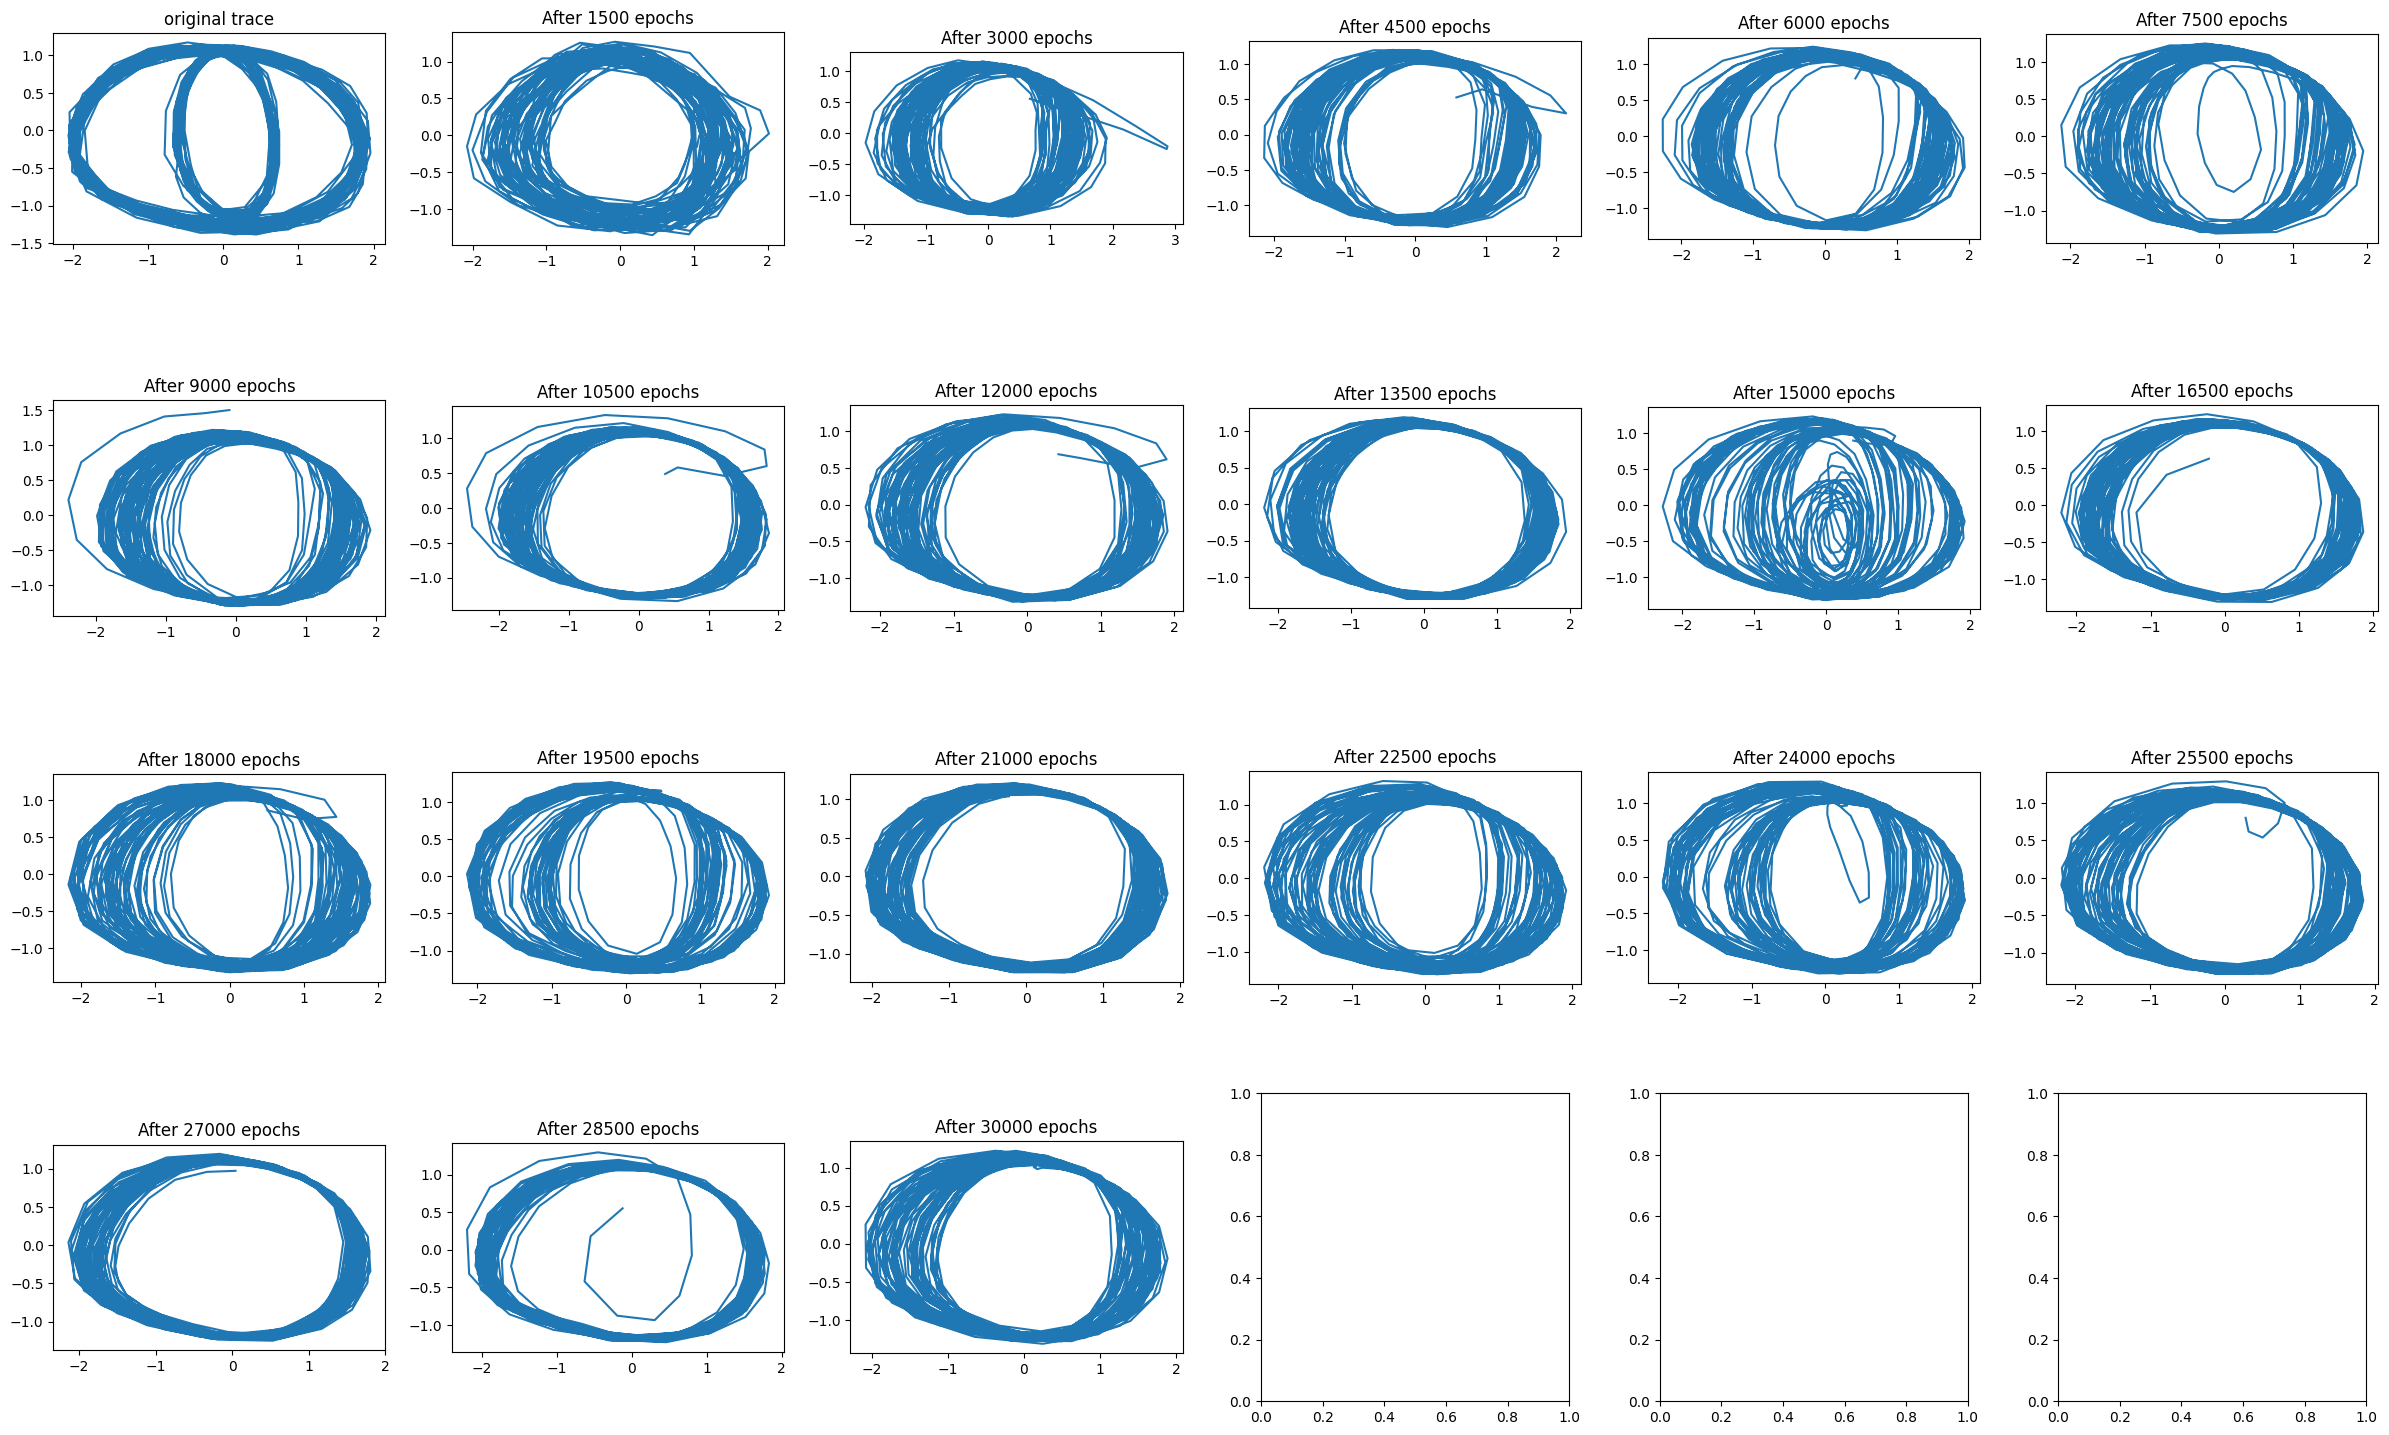

In [23]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5*n_cols, 4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates[0].cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

Text(0.5, 1.0, 'inferred trace')

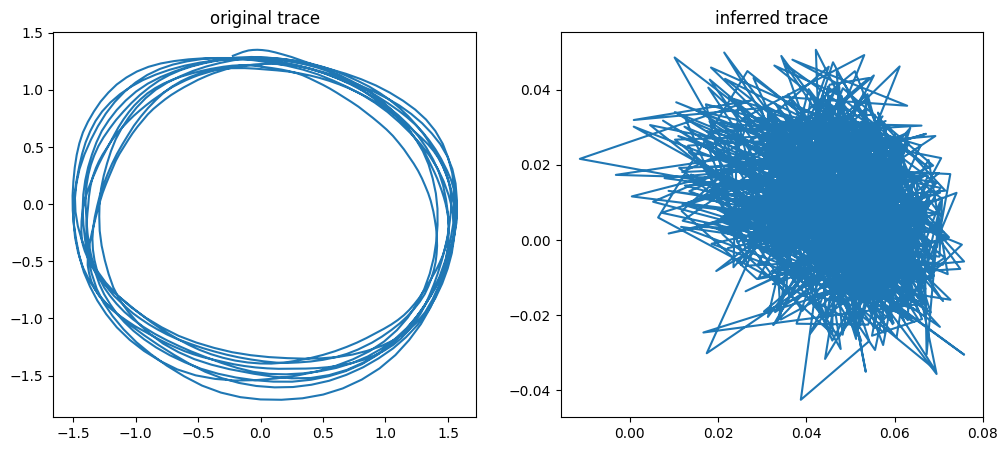

In [12]:
# Reconstruct with the inference mechanism
coords = coordinates[0]
x = pvrnn(coords)

gen_coords = x.cpu().detach().numpy()
orig_coords = coords.cpu().detach().numpy()

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
axs[0].plot(orig_coords[:,0], orig_coords[:,1])
axs[0].set_title("original trace")
axs[1].plot(gen_coords[:,0], gen_coords[:,1])
axs[1].set_title("inferred trace")

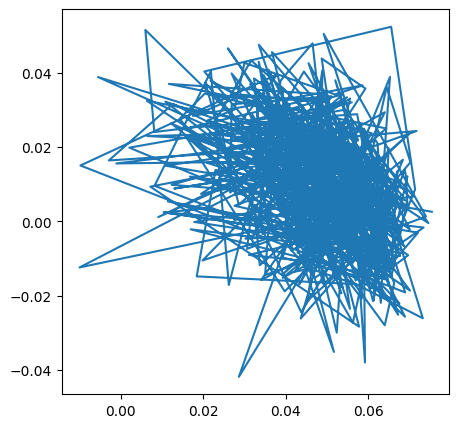

In [13]:
# generate a single trace 
gen_coords = pvrnn.generate(500).cpu().detach().numpy()
fig = plt.figure(figsize=(5,5))
plt.plot(gen_coords[:,0], gen_coords[:,1])

---
## Using GRU units

In [14]:
class VRNN_GRU(nn.Module):
    def __init__(self, x_conf, z_conf, prior_conf, enc_conf, dec_conf, f_conf):
        super(VRNN_GRU, self).__init__()
        self.phi_x = FFP(x_conf['sizes'],
                         x_conf['nltypes'],
                         x_conf['bias']).to(device)
        self.phi_z = FFP(z_conf['sizes'],
                         z_conf['nltypes'],
                         z_conf['bias']).to(device)
        self.phi_prior = normal_FFP(prior_conf['sizes'],
                                    prior_conf['nltypes'],
                                    prior_conf['bias'],
                                    prior_conf['use_soft']).to(device)
        self.phi_enc = normal_FFP(enc_conf['sizes'],
                                  enc_conf['nltypes'],
                                  enc_conf['bias'],
                                  enc_conf['use_soft']).to(device)
        self.phi_dec = normal_FFP(dec_conf['sizes'],
                                  dec_conf['nltypes'],
                                  dec_conf['bias'],
                                  dec_conf['use_soft']).to(device)
        self.f = nn.GRUCell(f_conf['sizes'][0],
                            f_conf['sizes'][1],
                            bias=f_conf['bias'],
                            device=device)
        
        self.h_n = f_conf['sizes'][-1]
        self.x_n = x_conf['sizes'][0]
        self.z_n = z_conf['sizes'][0]

    def forward(self, x):
        """ Perform inference for a sequence of inputs.

            Args:
                x: tensor with shape (T, x_n)
            Returns: 5-tuple with the following tensors
                inferred x values, shape (T, x_n)
                prior mu_z values, shape (T, n_z)
                prior sigma_z values, shape (T, n_z)
                mu_z vales from the encoder, shape (T, n_z)
                sigma_z values from the encoder, shape (T, n_z)
        """
        h = torch.zeros(self.h_n, device=device)
        T = x.shape[0]
        all_x_hat = torch.empty((T, self.x_n), device=device)
        all_prior_mu_z = torch.empty((T, self.z_n), device=device)
        all_prior_sigma_z = torch.empty((T, self.z_n), device=device)
        all_mu_z = torch.empty((T, self.z_n), device=device)
        all_sigma_z = torch.empty((T, self.z_n), device=device)
        for t in range(T):
            # extract features from x
            x_feat = self.phi_x(x[t])
            # pass x features through the encoder
            mu_z, sigma_z = self.phi_enc(torch.cat((x_feat, h)))
            # prior values of mu_z, sigma_z
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z with reparameterization
            eps = torch.randn_like(mu_z)
            z = eps.mul(sigma_z).add_(mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat)), h)
            # store results for time t
            all_x_hat[t, :] = x_hat
            all_prior_mu_z[t, :] = prior_mu_z
            all_prior_sigma_z[t, :] = prior_sigma_z
            all_mu_z[t, :] = mu_z
            all_sigma_z[t, :] = sigma_z

        return all_x_hat, all_prior_mu_z, all_prior_sigma_z, all_mu_z, all_sigma_z

    def generate(self, T):
        """ Generate a sequence of T synthetic values. """
        h = torch.zeros(self.h_n, device=device)
        all_x_hat = torch.empty((T, self.x_n), device=device)
        for t in range(T):
            # generate z's prior distribution
            prior_mu_z, prior_sigma_z = self.phi_prior(h)
            # sample z
            eps = torch.randn_like(prior_mu_z)
            z = eps.mul(prior_sigma_z).add_(prior_mu_z)
            # extract features from z
            z_feat = self.phi_z(z)
            # pass z_feat through the decoder
            mu_x, sigma_x = self.phi_dec(torch.cat((z_feat, h)))
            # sample x with reparameterization
            eps = torch.randn_like(mu_x)
            x_hat = eps.mul(sigma_x).add_(mu_x)
            # extract features from x_hat
            x_feat = self.phi_x(x_hat)
            # update the hidden state
            h = self.f(torch.cat((x_feat, z_feat)), h)
            # store x value
            all_x_hat[t, :] = x_hat
        return all_x_hat

In [21]:
# Create the GRU network, the optimizer, and the loss function
# NOTICE there are no batches. Learning a single pattern.

lr = 3e-4  # learning rate
x_n = 2  # Input dimension. This shouldn't change
h_n = 8 # hidden state dimension
z_n = 4  # latent space dimension
n_x_features = 4  # number of features to extract from inputs
n_z_features = 6  # number of features to extract from latent variables

phi_x_config = {'sizes': [x_n, n_x_features],
                'nltypes': ['relu'],
                'bias': True }
phi_z_config = {'sizes': [z_n, n_z_features],
                'nltypes': ['relu'],
                'bias': True }
phi_prior_config = {'sizes': [h_n, 20, z_n],
                    'nltypes': ['relu', 'linear'],
                    'bias': True,
                    'use_soft': False }
phi_enc_config = {'sizes': [n_x_features + h_n, 16, z_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': False }
phi_dec_config = {'sizes': [n_z_features + h_n, 20, x_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': True }
f_config = {'sizes': [n_x_features + n_z_features, h_n],
            'bias': True }

all_generated = []
torch.manual_seed(345)

vrnn_gru = VRNN_GRU(phi_x_config,
            phi_z_config,
            phi_prior_config,
            phi_enc_config,
            phi_dec_config,
            f_config)

optim = torch.optim.Adam(vrnn_gru.parameters(), lr=lr)
mse_loss = nn.MSELoss(reduction='mean')

In [23]:
# training loop
n_epochs = 20  # number of epochs
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)
    
if not 'w' in locals():
    w = 0.
alpha = 5e-7

for epoch in range(n_epochs):
    acc_RE = 0
    acc_DE = 0
    for coords in coordinates:
        optim.zero_grad()
        x, pmu, psig, mu, sig = vrnn_gru(coords)
        RE = mse_loss(x, coords)
        DE = KL_loss(mu, sig, pmu, psig)
        loss = RE + w * DE
        loss.backward()
        optim.step()
        with torch.no_grad():
            w += alpha * (RE - w * DE)
        acc_RE += RE
        acc_DE += DE
    acc_RE /= n_pats
    acc_DE /= n_pats
    if epoch % 5 == 0:
        print(f"RE = {acc_RE:.4f}, w*DE = {w * acc_DE:.4f}, w = {w:.6f} at epoch {epoch}")

RE = 0.0214, w*DE = 0.1147, w = 0.000024 at epoch 0
RE = 0.0206, w*DE = 0.1129, w = 0.000024 at epoch 1
RE = 0.0203, w*DE = 0.1111, w = 0.000023 at epoch 2
RE = 0.0200, w*DE = 0.1094, w = 0.000023 at epoch 3
RE = 0.0197, w*DE = 0.1077, w = 0.000023 at epoch 4
RE = 0.0195, w*DE = 0.1061, w = 0.000022 at epoch 5
RE = 0.0190, w*DE = 0.1044, w = 0.000022 at epoch 6
RE = 0.0189, w*DE = 0.1028, w = 0.000022 at epoch 7
RE = 0.0184, w*DE = 0.1012, w = 0.000021 at epoch 8
RE = 0.0181, w*DE = 0.0996, w = 0.000021 at epoch 9
RE = 0.0182, w*DE = 0.0981, w = 0.000021 at epoch 10
RE = 0.0175, w*DE = 0.0966, w = 0.000020 at epoch 11
RE = 0.0174, w*DE = 0.0951, w = 0.000020 at epoch 12
RE = 0.0170, w*DE = 0.0936, w = 0.000020 at epoch 13
RE = 0.0168, w*DE = 0.0922, w = 0.000019 at epoch 14
RE = 0.0164, w*DE = 0.0907, w = 0.000019 at epoch 15
RE = 0.0164, w*DE = 0.0893, w = 0.000019 at epoch 16
RE = 0.0161, w*DE = 0.0879, w = 0.000018 at epoch 17
RE = 0.0158, w*DE = 0.0866, w = 0.000018 at epoch 18
RE 

In [23]:
# Generate a trajectory
n_points = 1000

gen_coordinates = vrnn_gru.generate(n_points).cpu().detach().numpy()

all_generated.append(gen_coordinates)

In [26]:
# Train and generate trajectories
n_epicycles = 4
n_points = 1000
n_epochs = 100  # number of epochs per epicycle
alpha = 1e-7
r = 10.
n_pats = len(coordinates)
for i in range(n_pats):
    coordinates[i] = coordinates[i].to(device)

if not 'w' in locals():
    w = 0.

for epi in range(n_epicycles):
    for epoch in range(n_epochs):
        acc_RE = 0
        acc_DE = 0
        for coords in coordinates:
            optim.zero_grad()
            x, pmu, psig, mu, sig = vrnn_gru(coords)
            RE = mse_loss(x, coords)
            DE = KL_loss(mu, sig, pmu, psig)
            loss = RE + w * DE
            loss.backward()
            optim.step()
            with torch.no_grad():
                w += alpha * (r * RE - w * DE)
            acc_RE += RE
            acc_DE += DE
        acc_RE /= n_pats
        acc_DE /= n_pats
        if epoch % 5 == 0:
            print(f"RE = {acc_RE:.4f}, w*DE = {w * acc_DE:.4f}, w = {w:.6f} at epoch {epoch}")
    print(f"epicycle {epi} completed.")
    print("-------------------------------------------------------")
        
    # Generate a trajectory
    gen_coordinates = vrnn_gru.generate(n_points).cpu().detach().numpy()
    
    all_generated.append(gen_coordinates)

RE = 0.0533, w*DE = 0.1957, w = 0.000091 at epoch 0
RE = 0.0556, w*DE = 0.1962, w = 0.000091 at epoch 5
RE = 0.0519, w*DE = 0.1965, w = 0.000091 at epoch 10
RE = 0.0524, w*DE = 0.1958, w = 0.000091 at epoch 15
RE = 0.0521, w*DE = 0.1963, w = 0.000091 at epoch 20
RE = 0.0530, w*DE = 0.1972, w = 0.000091 at epoch 25
RE = 0.0524, w*DE = 0.1971, w = 0.000092 at epoch 30
RE = 0.0492, w*DE = 0.1969, w = 0.000092 at epoch 35
RE = 0.0506, w*DE = 0.1974, w = 0.000092 at epoch 40
RE = 0.0499, w*DE = 0.1975, w = 0.000092 at epoch 45
RE = 0.0498, w*DE = 0.1986, w = 0.000092 at epoch 50
RE = 0.0496, w*DE = 0.1978, w = 0.000092 at epoch 55
RE = 0.0472, w*DE = 0.1980, w = 0.000093 at epoch 60
RE = 0.0480, w*DE = 0.1986, w = 0.000093 at epoch 65
RE = 0.0473, w*DE = 0.1985, w = 0.000093 at epoch 70
RE = 0.0479, w*DE = 0.1996, w = 0.000093 at epoch 75
RE = 0.0458, w*DE = 0.1986, w = 0.000093 at epoch 80
RE = 0.0472, w*DE = 0.1994, w = 0.000093 at epoch 85
RE = 0.0473, w*DE = 0.1991, w = 0.000093 at epoc

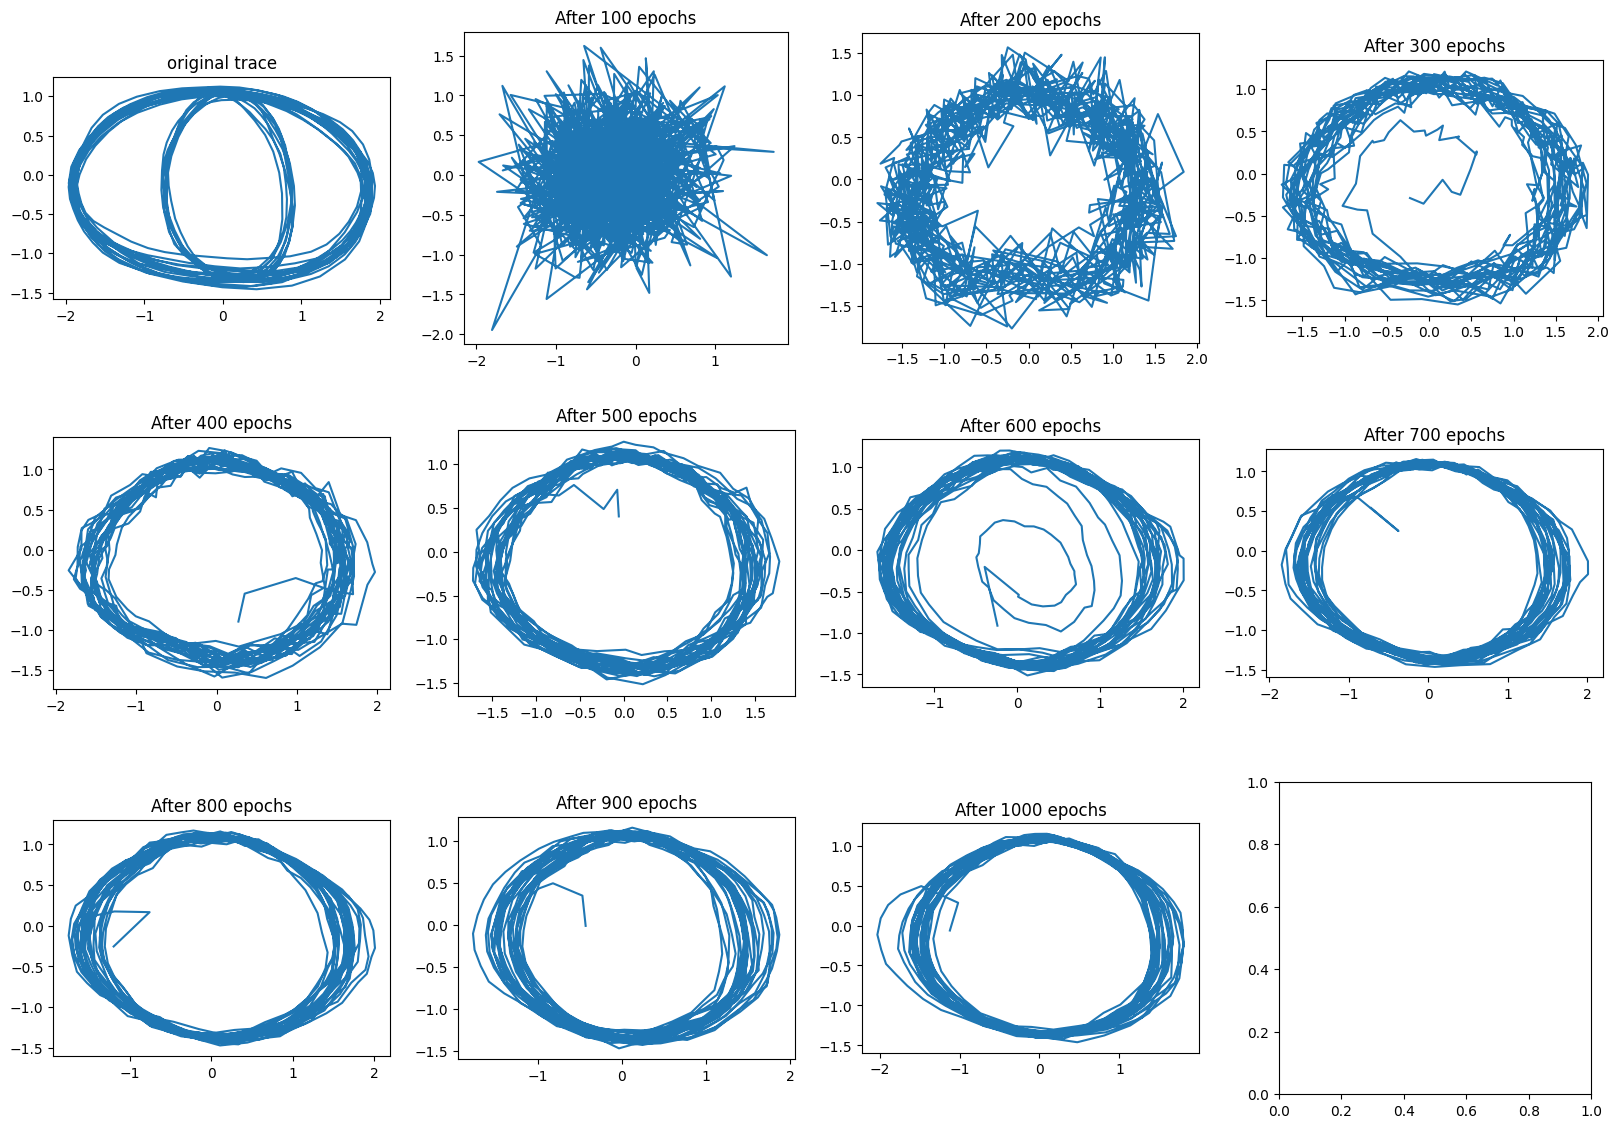

In [11]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5*n_cols, 4.6*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates[0].cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

---
## Save the state of a network

In [51]:
# Save the state of a network
torch.save(vrnn.state_dict(), 'cte_nz10_3000e.pth')

In [ ]:
# load model
x_n = 2  # Input dimension. This shouldn't change
h_n = 60 # hidden state dimension
z_n = 10  # latent space dimension
n_x_features = 15  # number of features to extract from inputs
n_z_features = 15  # number of features to extract from latent variables

phi_x_config = {'sizes': [x_n, n_x_features],
                'nltypes': ['relu'],
                'bias': True }
phi_z_config = {'sizes': [z_n, n_z_features],
                'nltypes': ['relu'],
                'bias': True }
phi_prior_config = {'sizes': [h_n, 20, z_n],
                    'nltypes': ['relu', 'linear'],
                    'bias': True,
                    'use_soft': False }
phi_enc_config = {'sizes': [n_x_features + h_n, 20, z_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': False }
phi_dec_config = {'sizes': [n_z_features + h_n, 20, x_n],
                  'nltypes': ['relu', 'linear'],
                  'bias': True,
                  'use_soft': True }
f_config = {'sizes': [n_x_features + n_z_features + h_n, h_n],
            'nltypes': ['tanh'],
            'bias': True }

model = VRNN(phi_x_config,
            phi_z_config,
            phi_prior_config,
            phi_enc_config,
            phi_dec_config,
            f_config)
model.load_state_dict(torch.load('cte_nz10_3000e.pth'))
